# Introduction

In this jupyter notebook, we will present the way we analysed, processed the dataset and the modeling of the machine learning algorithm to detect the fraudulent transactions. 

![alt text](fraud.jpg "Title")

## Data Exploration

The dataset [ https://www.kaggle.com/mlg-ulb/creditcardfraud ] consists of transactions done with credit cards in September 2013 by European cardholders. It contains only numerical input variables which are the product of a Principal Component Analysus (PCA). Thus, due to privacy issues the original features are not availablle and we don't know what the V1...V28 features represent expect from the Amount, Time and Class. Totally, there are 31 features. 

The feature 'Amount' is the amount of a transaction, 'Time' is the seconds elapsed between each transaction and the first transaction and 'Class' represents a fraud transaction when its value equals to 1 and a valid transaction when its value equals to 0.

Starting from this assumption, let's start with our data exploration.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

In [4]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

sc = pyspark.SparkContext(appName = "credit_card_fraud")
spark = SparkSession(sc)

Here, we read the dataset from the csv file using pandas and then we checked if there are missing values before going on with other analysis. Then, we just call the head() and describe() functions to have an overall idea of our dataset. Since there will be no missing values we can proceed with other visualizations.

In [5]:
df = pd.read_csv("./creditcard.csv")
print("missing values: ", df.isnull().values.any())

missing values:  False


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Plotting

We tried to plot the two not anonymized features, that as we said are 'Time' and 'Amount'. 

From the Time Distribution we can understand it is bimodal. This indicates that approximately 28 hours after the first transaction there was a drop in the volume. The timestamp is not provided but as hypothesis it would be reasonable to assume that the drop is caused by a drop in the number of transactions during night. We can infer this by the fact that time is provided in seconds hence should be about two days of transactions. 

From the Amount Distribution we can derive it is skewed. Most of the transactions are small and a little percentage are higher. 

Finally, we plotted the Non Fraud and Fraud transactions over time but there are no meaningful things we can derive. 

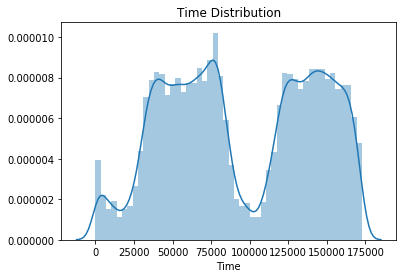

In [8]:
plt.figure(figsize = (6,4))
plt.title('Time Distribution')
sns.distplot(df['Time'])

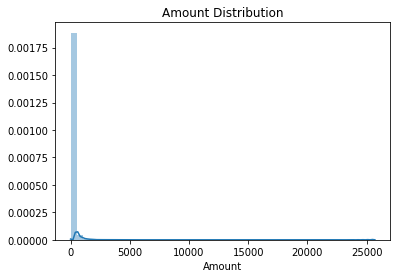

In [9]:
plt.figure(figsize = (6,4))
plt.title('Amount Distribution')
sns.distplot(df['Amount'])

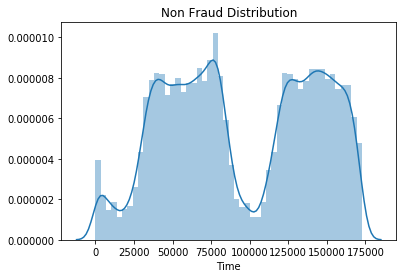

In [10]:
plt.figure(figsize = (6,4))
plt.title('Non Fraud Distribution')
sns.distplot(df['Time'][df['Class'] == 0])

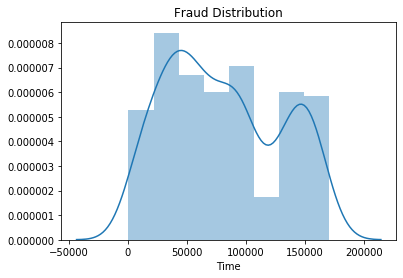

In [11]:
plt.figure(figsize = (6,4))
plt.title('Fraud Distribution')
sns.distplot(df['Time'][df['Class'] == 1])

At this point, we tried to understand how the transactions are distributed among the two classes of 'Fraud' and 'Non Fraud'. We derived the data and plotted a bar chart to explain it. Thus, we understood that the dataset has just few fraudulent transactions, which are 0.173% of the total. 

Therefore, we are dealing with a highly unbalanced dataset and with a class of problems known as class imbalance. By studying the problem we discovered that it is very common in fraud detection problems to have this issue.  

Stated that, it is not possible to use directly a machine learning algorithm otherwise it will overfit the data on the 'Non Fraud' samples. A good idea to have a not biased result is to reduce classes samples to be more or less equal.
The main problem is that if there are few 'Fraud' samples, there is too few data to infer patterns from them. 

In [12]:
frauds_df = df[df['Class'] == 1]
non_frauds_df = df[df['Class'] == 0]

frauds_number = len(frauds_df)
non_frauds_number = len(non_frauds_df)

print("fraudelent transactions are " + str(frauds_number))
print("non fraudelent transaction are " + str(non_frauds_number))

ratio = (float(frauds_number) / float(non_frauds_number)) * 100
print("frauds are " + str(ratio)[:5] + "% of the total")

fraudelent transactions are 492
non fraudelent transaction are 284315
frauds are 0.173% of the total


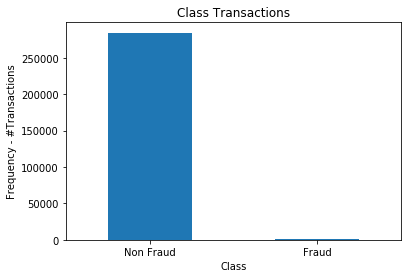

In [13]:
classes = pd.value_counts(df['Class'], sort=True)
classes.plot(kind = 'bar', rot=0)

plt.title("Class Transactions")
plt.xticks(range(2), ['Non Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency - #Transactions")
plt.show()

We don't know the features but we can understand if there is a correlation between them, hence we plotted an heatmap with correlations. We infered that there are no highly correlated features. There's a just a slightly negative correlation between V2 and Amount. And some features seem to have little correlations with the label 'Class' maybe due to the PCA. 

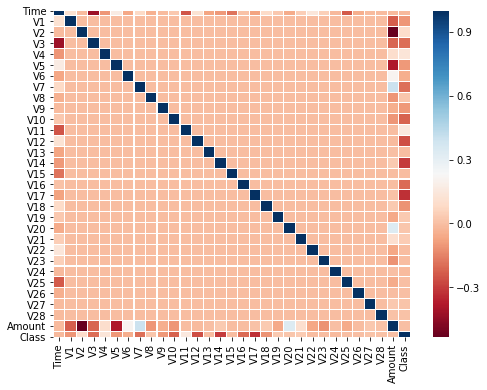

In [14]:
correlations = df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlations, 
            xticklabels=correlations.columns, 
            yticklabels=correlations.columns,
            linewidths=.1, cmap="RdBu", ax=ax)

To visualize differently the distribution of data, we used T-SNE, which is a data decomposition technique that reduces data into specific dimensions and displays the top n dimensions with maximum information, a technique similar to PCA. A lot of Non Fraud transactions overlap with the Fraud transactions hence they are difficult to divide with a linear boundary. 

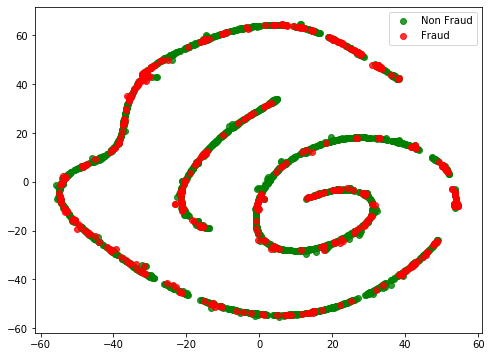

In [15]:
non_fraud_tsne = df[df['Class'] == 0].sample(2000)
fraud_tsne = df[df['Class'] == 1]

#frac = 1 retains the 100% of the fraud dataframe
df_tsne = non_fraud_tsne.append(fraud_tsne).sample(frac = 1)
#drop the index columns 
df_tsne = df_tsne.reset_index(drop = True)

x = df_tsne.drop(['Class'], axis = 1).values
y = df_tsne['Class'].values

p = TSNE(n_components=2, random_state=24).fit_transform(x)

plt.figure(figsize=(8, 6))
plt.scatter(p[np.where(y == 0), 0], p[np.where(y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
plt.scatter(p[np.where(y == 1), 0], p[np.where(y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
plt.legend(loc='best')
plt.show()

## Data Preparation


All the anonymized features have been scaled and centered around zero while 'Time' and 'Amount' have been not. To have a better performance with the Logistic Regression, the ML algorithm that we will use later, is necessary to scale them as weel. 

To prepare our data as input to the ML we need to:
- preprocess time and amount witn StandardScaler
- split dataset into train and test set
- deal with the highly unbalanced dataset

The StandardScaler will transform the data to have a distribution will with mean value 0 and a standard deviation of 1. Transform the data is crucial to be correctly interpreted by the algorithm.

In [16]:
# scaling TIME to be centered around zero 
scaler_time = StandardScaler()

scaled_time = scaler_time.fit_transform(df[['Time']])
scaled_time_list = scaled_time.tolist()

flat_time = [item for sublist in scaled_time_list for item in sublist]
scaled_time = pd.Series(flat_time)

#print(scaled_time)

In [17]:
# scaling AMOUNT to be centered around zero 
scaler_amount = StandardScaler()

scaled_amount = scaler_amount.fit_transform(df[['Amount']])
scaled_amount_list = scaled_amount.tolist()

flat_amount= [item for sublist in scaled_amount_list for item in sublist]
scaled_amount = pd.Series(flat_amount)

#print(scaled_amount)

In [18]:
# Add the new two columns to the dataframe and check it is everything ok

df_scaled = pd.concat([df, scaled_amount.rename('Amount_Scaled'), scaled_time.rename('Time_Scaled')], axis=1)
df_scaled.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_Scaled,Time_Scaled
54651,46542.0,-0.779711,-0.500589,1.945499,-0.875214,-1.551944,1.479649,0.069009,0.306299,-1.107497,...,-0.040549,-0.214414,-0.301730,0.040173,0.162260,0.069728,239.50,0,0.604312,-1.016505
44354,41912.0,1.085276,-0.074766,1.395381,1.372598,-0.962361,0.074793,-0.631575,0.208962,0.871186,...,0.064939,0.397002,0.296721,-0.399117,0.089119,0.038141,9.99,0,-0.313289,-1.114003
118025,74920.0,1.181341,-0.547368,0.907319,0.486555,-1.166149,0.068637,-0.918526,0.272897,-0.820675,...,0.032019,0.156655,0.248570,-0.247055,0.067870,0.023693,22.00,0,-0.265271,-0.418923
117052,74523.0,1.047386,0.115877,0.490427,2.654748,-0.229108,0.017744,0.053816,0.043147,-0.120996,...,-0.092403,-0.163613,0.485485,-0.064072,-0.021937,0.027921,82.44,0,-0.023627,-0.427283
102642,68295.0,-3.766116,-3.529451,1.556402,0.477386,-0.130375,-1.150667,-0.206098,-0.041438,1.523686,...,-0.463796,0.881097,0.020469,0.902429,-0.568034,-0.454285,261.76,0,0.693310,-0.558432


In [19]:
# Drop columns with no normalized values

df_scaled.drop(['Amount', 'Time'], axis = 1, inplace = True)
df_scaled.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_Scaled,Time_Scaled
210918,-1.942564,2.273353,-1.388581,-0.848815,0.790632,0.724401,-0.659293,-2.624202,0.299560,-0.676094,...,-0.791231,0.173886,-0.304875,-0.040264,0.573044,-0.039580,0.223783,0,-0.334278,0.913264
26180,-0.423833,0.929508,1.222696,0.848953,0.287704,-0.379155,0.579813,0.000857,-0.409845,-0.105179,...,0.523221,-0.135151,0.061538,-0.384878,-0.313835,0.053820,0.160229,0,-0.333239,-1.281835
48082,-1.107839,0.168790,0.761982,-1.960236,-0.504221,-0.294342,-0.215795,0.451860,-1.346098,0.135195,...,-0.304122,-0.076927,-0.579281,-0.381310,-0.670014,-0.256682,0.044517,0,-0.145329,-1.080816
93411,-0.997680,0.018658,0.391047,-1.629481,3.228123,3.052738,0.311843,0.686148,-0.533164,-0.561364,...,-0.117723,-0.299212,1.028478,0.712251,0.310843,-0.214138,-0.166272,0,-0.208139,-0.640369
109991,-0.678419,1.032228,1.542239,0.033214,0.390982,-0.960363,0.868789,-0.188937,-0.481934,-0.551188,...,0.171863,-0.156868,0.381001,-0.106546,-0.659527,-0.007906,0.161963,0,-0.343274,-0.488183


In [20]:
# reindexing dataframe with a correct order 

columns_titles = ['V1','V2','V3','V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Scaled', 'Time_Scaled', 'Class']
df_scaled = df_scaled.reindex(columns = columns_titles)
df_scaled.sample(5)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled,Time_Scaled,Class
166098,1.933102,0.422095,-0.809665,3.771685,0.613019,0.455908,0.061436,0.017551,-0.585853,1.379594,...,0.266639,0.078744,0.461229,0.182068,0.080505,-0.034437,-0.046422,-0.308011,0.485283,0
110914,-0.536153,0.679394,2.633284,0.127527,-0.114955,-0.159848,0.558465,-0.120408,0.334534,-0.739179,...,0.352373,-0.210094,0.412482,-0.092528,-0.644528,0.000445,-0.079416,-0.313289,-0.479907,0
24334,-1.819602,-1.085549,0.578706,0.615357,-1.083010,0.455029,2.934105,-0.193961,-0.817227,-1.193433,...,0.575021,1.384951,0.005664,0.244506,-0.471078,-0.099653,0.190265,2.293464,-1.297860,0
200307,1.347820,-1.320745,-1.024153,0.465419,0.100938,1.503196,-0.297769,0.424432,0.791367,-0.114474,...,-0.837010,0.225543,-1.652476,-0.821541,-0.067103,-0.025358,-0.022647,0.746244,0.812207,0
22515,-1.455444,-0.455972,2.351831,-0.565761,-0.686836,0.555714,1.114825,-0.384231,-1.267266,0.733456,...,0.192713,0.073370,0.189856,0.304117,-0.438668,-0.296126,-0.437609,0.494365,-1.316749,0


Now we can observe that fraud and non-fraud transactions are distinguishable and linearly separable to some extente. 

In [21]:
# feature Matrix
#X = df_scaled.drop('Class', axis = 1)

# target Vector
#y = df_scaled['Class']

#X_TSNE = X.values
#y_TSNE = y.values

#z = TSNE(n_components = 2, random_state = 24).fit_transform(X_TSNE)

#plt.figure(figsize=(8, 6))
#plt.scatter(z[np.where(y_TSNE == 0), 0], z[np.where(y_TSNE == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
#plt.scatter(z[np.where(y_TSNE == 1), 0], z[np.where(y_TSNE == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')
#plt.legend(loc = 'best')
#plt.show()

### Data Splitting

In [22]:
# casting all columns to double 

df_spark = spark.createDataFrame(df_scaled)
df_spark = df_spark.withColumn('Class', df_spark['Class'].cast('double'))
df_spark.printSchema()

root
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nullable = true)
 |-- Amount_Scaled: doub

In [23]:
df_spark.head()

Row(V1=-1.3598071336738, V2=-0.0727811733098497, V3=2.53634673796914, V4=1.37815522427443, V5=-0.33832076994251803, V6=0.462387777762292, V7=0.239598554061257, V8=0.0986979012610507, V9=0.363786969611213, V10=0.0907941719789316, V11=-0.551599533260813, V12=-0.617800855762348, V13=-0.991389847235408, V14=-0.31116935369987897, V15=1.46817697209427, V16=-0.47040052525947795, V17=0.20797124192924202, V18=0.0257905801985591, V19=0.403992960255733, V20=0.251412098239705, V21=-0.018306777944153, V22=0.277837575558899, V23=-0.110473910188767, V24=0.0669280749146731, V25=0.12853935827352803, V26=-0.189114843888824, V27=0.13355837674038698, V28=-0.0210530534538215, Amount_Scaled=0.24496426337017338, Time_Scaled=-1.996583023457193, Class=0.0)

In [24]:
ml_df = df_spark.rdd.map(lambda x: (DenseVector(x[0:30]), x[30]))
ml_df = spark.createDataFrame(ml_df, ["features", "label"])
ml_df.head()
#ml_df.select("features").show()
#ml_df.groupBy("label").count().show()

Row(features=DenseVector([-1.3598, -0.0728, 2.5363, 1.3782, -0.3383, 0.4624, 0.2396, 0.0987, 0.3638, 0.0908, -0.5516, -0.6178, -0.9914, -0.3112, 1.4682, -0.4704, 0.208, 0.0258, 0.404, 0.2514, -0.0183, 0.2778, -0.1105, 0.0669, 0.1285, -0.1891, 0.1336, -0.0211, 0.245, -1.9966]), label=0.0)

In [25]:
ml_df = ml_df.select("features","label")
train_data, test_data = ml_df.randomSplit([.8,.2],seed=1234)

In [26]:
train_data.head()

Row(features=DenseVector([-30.5524, 16.7134, -31.1037, 6.535, -22.1055, -4.9777, -20.3715, 20.0072, -3.5657, -7.7311, 3.8294, -5.3143, 1.4469, -4.5793, -0.1423, -4.9978, -10.9614, -4.6415, 0.5671, 1.7336, 1.8165, -2.2887, -1.4605, 0.1832, 2.2082, -0.2088, 1.2326, 0.3567, 0.0465, -1.3911]), label=1.0)

In [27]:
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|227770|
|  1.0|   403|
+-----+------+



In [28]:
test_data.head()

Row(features=DenseVector([-29.8764, 16.4345, -30.5587, 6.5059, -21.6657, -4.9404, -20.0814, 19.5878, -3.5915, -7.8006, 3.9478, -5.4879, 1.3699, -4.8296, -0.1344, -5.1212, -11.1182, -4.66, 0.6089, 1.7248, 1.813, -2.2323, -1.4128, 0.1787, 2.156, -0.2094, 1.2556, 0.3645, 0.0465, -1.3917]), label=1.0)

In [29]:
test_data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|56545|
|  1.0|   89|
+-----+-----+



### Balancing the Dataset

The dataset is highly unbalanced since there's a skew in the class distribution. Thus, our training dataset could be biased and influence the ML algorithm when displaying results. To address this problem we randomly balance the data to have the same number of fraudelent and non fraudulent transactions. 

To do that, we retrieve from the training data a dataframe with the frauds and a dataframe with the non frauds. After that, we concatenated the two to obtain a balanced dataset. In this way, we created a subsample dataset with balanced class distribution

In [30]:
fraud_df_spark = train_data.filter("label=1.0")
non_fraud_df_spark = train_data.filter("label=0.0")

print(fraud_df_spark.count())
print(non_fraud_df_spark.count())

ratio = fraud_df_spark.count() / non_fraud_df_spark.count()

non_fraud_sample_df_spark = non_fraud_df_spark.sample(False, ratio)

balanced_df = fraud_df_spark.unionAll(non_fraud_sample_df_spark)

403
227770


In [31]:
# dataframe spark to dataframe pandas
balanced_dfp = balanced_df.toPandas()
balanced_dfp.head()
number = balanced_df.count()

The plot below shows that now we have a balanced dataset, where the number of frauds is equal to the number of non fraudulent transactions.

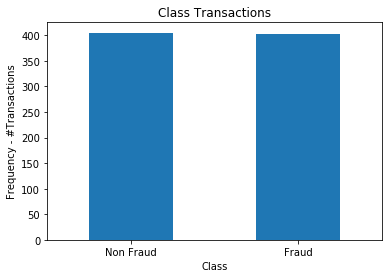

In [32]:
new_classes = pd.value_counts(balanced_dfp['label'], sort=True)
new_classes.plot(kind = 'bar', rot=0)

plt.title("Class Transactions")
plt.xticks(range(2), ['Non Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Frequency - #Transactions")
plt.show()

### Correlations

In [33]:
columns_titles = ['V1','V2','V3','V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Scaled', 'Time_Scaled', 'Label']
correlations_df = pd.DataFrame(columns=columns_titles)

for i in range(number):
    
    features_value_list = balanced_dfp['features'].iloc[i].tolist()
    label = balanced_dfp['label'].iloc[i]
    features_value_list.append(label)
    features_value_array = np.asarray(features_value_list)
    temp = pd.DataFrame([features_value_array], columns=columns_titles)
    correlations_df = correlations_df.append(temp, ignore_index=True)

correlations_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled,Time_Scaled,Label
0,-30.552380,16.713389,-31.103685,6.534984,-22.105532,-4.977692,-20.371514,20.007208,-3.565738,-7.731071,...,-2.288686,-1.460544,0.183179,2.208209,-0.208824,1.232636,0.356660,0.046539,-1.391062,1.0
1,-29.200329,16.155701,-30.013712,6.476731,-21.225810,-4.902997,-19.791248,19.168327,-3.617242,-7.870122,...,-2.175815,-1.365104,0.174286,2.103868,-0.209944,1.278681,0.372393,0.046539,-1.392389,1.0
2,-28.524268,15.876923,-29.468732,6.447591,-20.786000,-4.865613,-19.501084,18.748872,-3.642990,-7.939642,...,-2.119376,-1.317450,0.169846,2.051687,-0.210502,1.301734,0.380246,0.046539,-1.393105,1.0
3,-27.848181,15.598193,-28.923756,6.418442,-20.346228,-4.828202,-19.210896,18.329406,-3.668735,-8.009159,...,-2.062934,-1.269843,0.165409,1.999499,-0.211059,1.324809,0.388090,0.046539,-1.393800,1.0
4,-27.143678,15.365804,-28.407424,6.370895,-20.087878,-4.666313,-18.709479,17.903574,-3.722279,-8.120962,...,-1.960974,-0.902247,0.144011,2.024388,-0.204214,1.332153,0.385891,0.046539,-1.403950,1.0


Now that we have a balanced dataset, the correlation matrix shows meaningful correlation between some features, differently from the correlation matrix displayed before

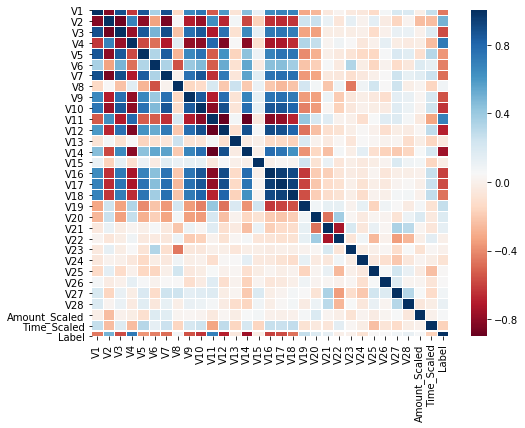

In [34]:
correlations = correlations_df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlations, 
            xticklabels=correlations.columns, 
            yticklabels=correlations.columns,
            linewidths=.1, cmap="RdBu", ax=ax)

## Classification Modeling

We are going to utilize a ML classification algorith to train our data and pick up the specific characterstics that make a transaction more or less likely to be fraudulent. 

Performance Evaluation is done on ROC-AUC. It outputs a value between zero and one. If it is above 0.5 it is better than random guessing. 

### Training

It has been used a logistic regression. Logistic regression models are used to determine the odds of a certain class or event existing. In our case, it will establish the probability of a transaction belonging to Class 0 or 1, which is normal or fraudulent.

In [35]:
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features").setMaxIter(30).setRegParam(0.3).setElasticNetParam(0.8)

lr_model = lr.fit(balanced_df)

### Testing

Now, let's evaluate our model with the test dataset

In [36]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.show()
lr_predictions.select("prediction", "rawPrediction", "label", "features").show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-29.876365513976...|  1.0|[-0.3729661453077...|[0.40782449119477...|       1.0|
|[-28.344757250015...|  0.0|[-0.0967343510714...|[0.47583525283228...|       1.0|
|[-22.382092095390...|  0.0|[0.37449347648300...|[0.59254431290500...|       0.0|
|[-21.567419280019...|  0.0|[0.17384061464807...|[0.54335103423591...|       0.0|
|[-21.353056221829...|  0.0|[0.32838767166411...|[0.58136702088440...|       0.0|
|[-21.209119592791...|  1.0|[-0.5832915009367...|[0.35817557152948...|       1.0|
|[-20.532751076435...|  1.0|[-0.5992682517702...|[0.35451112407503...|       1.0|
|[-18.018561187677...|  1.0|[-1.2712074147925...|[0.21905063264976...|       1.0|
|[-16.367923010796...|  1.0|[-1.3270380254273...|[0.20964973261164...|       1.0|
|[-16.2556423199

In [37]:
training_summary = lr_model.summary
print(training_summary)

lr_f1_evaluator = MulticlassClassificationEvaluator().setMetricName("f1").setLabelCol("label").setPredictionCol("prediction")
lr_f1 = lr_f1_evaluator.evaluate(lr_predictions)

training_summary.roc.show()
print("area Under ROC: " + str(training_summary.areaUnderROC))
print("F1-Score: " + str(lr_f1))

+---+--------------------+
|FPR|                 TPR|
+---+--------------------+
|0.0|                 0.0|
|0.0|0.017369727047146403|
|0.0|0.034739454094292806|
|0.0| 0.05459057071960298|
|0.0|  0.0794044665012407|
|0.0| 0.09925558312655088|
|0.0| 0.11662531017369727|
|0.0| 0.13399503722084366|
|0.0| 0.15384615384615385|
|0.0| 0.17369727047146402|
|0.0| 0.19106699751861042|
|0.0| 0.21339950372208435|
|0.0| 0.23076923076923078|
|0.0| 0.24813895781637718|
|0.0|  0.2630272952853598|
|0.0|  0.2803970223325062|
|0.0|  0.2977667493796526|
|0.0|   0.315136476426799|
|0.0|  0.3325062034739454|
|0.0| 0.34987593052109184|
+---+--------------------+
only showing top 20 rows

area Under ROC: 0.9788040314922035
F1-Score: 0.9973287962598861


In [38]:
prediction_labels = lr_predictions.rdd.map(lambda x: (float(x.prediction), float(x.label)))

metrics = BinaryClassificationMetrics(prediction_labels)

print("Area under PR = %s" % metrics.areaUnderPR)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under PR = 0.2565421948102993
Area under ROC = 0.9028850443268313


### Save model

commented code for saving LogisticRegressionModel on the disk for future use

In [39]:
'''from pyspark.ml.classification import LogisticRegressionModel

lrModel.write().save("./LRModelSpark2")'''

'from pyspark.ml.classification import LogisticRegressionModel\n\nlrModel.write().save("./LRModelSpark2")'